## Load Dependencies

In [1]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

import os
import sys
import glob
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests

import torch
from torchvision import transforms
from PIL import Image

[2024-05-24 12:07:12] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/naufal/sg_logs/console.log


## Load Test Image

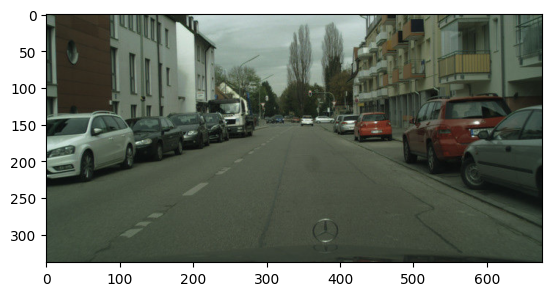

In [2]:
url = "https://cdn-media.huggingface.co/Inference-API/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle.png"
cityscape_img = np.array(Image.open(requests.get(url, stream=True).raw))

plt.imshow(cityscape_img)
plt.show()

## Load Model

In [3]:
# Load Model
model = models.get(
    model_name=Models.DDRNET_23,
    pretrained_weights="cityscapes",
)

model.eval()

MODEL_WIDTH = 2048
MODEL_HEIGHT = 1024

[2024-05-24 12:07:14] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the cityscapes dataset, published under the following terms: https://www.cs.toronto.edu/~kriz/cifar.html
[2024-05-24 12:07:15] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture ddrnet_23


In [4]:
def preprocess_ss(image, device):
    # Check if the image is not a tensor
    if not torch.is_tensor(image):
        # Convert the image to a tensor
        image = transforms.ToTensor()(image).unsqueeze(0)

    # Resize the image to the MDE input size
    image = transforms.Resize(
        (MODEL_HEIGHT, MODEL_WIDTH),
        interpolation=transforms.InterpolationMode.BILINEAR,
    )(image)

    # Normalize the image
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(
        image
    )

    image = image.to(device)

    return image


def predict_ss(tensor_imgs, original_shape):
    # PREDICTION
    logits = model(tensor_imgs)
    logits_reshape = torch.nn.functional.interpolate(
        logits, size=original_shape, mode="bilinear", align_corners=False
    )
    probs = torch.softmax(logits_reshape, dim=1)

    return probs

In [5]:
# Put the model on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Moving model to {device}")

## Define Class Label

In [6]:
# Define cityscapes labels and colors
cityscapes_labels = [
    "road",
    "sidewalk",
    "building",
    "wall",
    "fence",
    "pole",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "train",
    "motorcycle",
    "bicycle",
]
cityscapes_colors = [
    (128, 64, 128),
    (244, 35, 232),
    (70, 70, 70),
    (102, 102, 156),
    (190, 153, 153),
    (153, 153, 153),
    (250, 170, 30),
    (220, 220, 0),
    (107, 142, 35),
    (152, 251, 152),
    (70, 130, 180),
    (220, 20, 60),
    (255, 0, 0),
    (0, 0, 142),
    (0, 0, 70),
    (0, 60, 100),
    (0, 80, 100),
    (0, 0, 230),
    (119, 11, 32),
]

In [7]:
def plot_ss_results(image, probs):
    # Get the predicted class labels
    pred_labels = torch.argmax(probs, dim=1)

    # Convert the predicted labels to a numpy array
    pred_labels_np = pred_labels.squeeze().detach().cpu().numpy()

    # Resize the predicted labels to the original image size
    pred_labels_np = np.array(
        Image.fromarray(pred_labels_np.astype(np.uint8))
    )  # .resize(size=cityscape_img.size, resample=Image.NEAREST))

    # Create a color pallette, selecting a color for each class
    color_palette = np.array(cityscapes_colors, dtype=np.uint8)

    # Apply the color pallette to the predicted labels
    pred_labels_colored = color_palette[pred_labels_np]

    plt.figure(figsize=(5, 5))
    plt.subplot(211)
    plt.imshow(image)
    plt.title("Input", fontsize=22)
    plt.axis("off")

    plt.subplot(212)
    plt.imshow(pred_labels_colored)
    plt.title("Segmented Image", fontsize=22)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## Perform Inference

/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


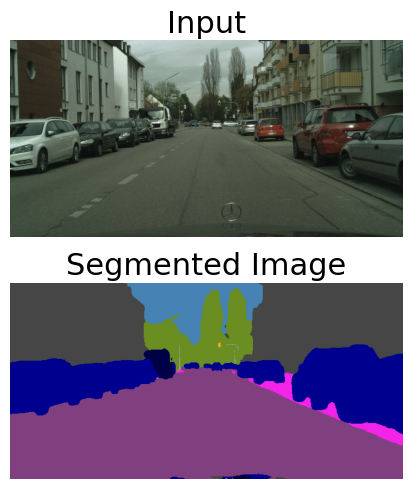

In [9]:
with torch.no_grad():
    tensor_imgs = preprocess_ss(cityscape_img, device)
    probs = predict_ss(tensor_imgs, cityscape_img.shape[:2])

plot_ss_results(cityscape_img, probs)